In [1]:
# ---
# Basic set up
# ---
%matplotlib inline

import numpy as np
from math import *
import pickle
import scipy.interpolate as interpolate
from matplotlib.colors import LogNorm
import matplotlib.pyplot as pyplt
import cosmolopy.distance as cosdist
import time

# set up cosmology
cosmo = {'omega_M_0' : 0.304, 'omega_lambda_0' : 0.696, 'h' : 0.68}
cosmo = cosdist.set_omega_k_0(cosmo)

In [2]:
# ---
# Define variables etc
# ---
# path to output catalog
PATH2OUTCAT     =       "mock_xi_mgas.ascii"

# scaling relations
# xi-mass relation - from email sent by Sebastian on 15th Apr, 2016
# This xi-M relation is fixed ALL TIME.
sr_xi_m =   {   
    "A"      :   3.49,
    "Aerr"   :   0.20, # not used
    "B"      :   1.65,
    "Berr"   :   0.09, # not used
    "C"      :   0.41,
    "Cerr"   :   0.16, # not used
    "D"      :   0.20,
    "Derr"   :   0.07, # not used
    "Mpiv"   :   3E14, # This is in the unit of Msun/h
    "zpiv"   :   0.60,
 }

# obs-mass relation (e.g., Mgas - M or whatever)
# obs
sr_obs_m =   {
    "A"      :   5E13,
    "Aerr"   :   5E12, # not used
    "B"      :   1.30,
    "Berr"   :   0.10, # not used
    "C"      :   0.00,
    "Cerr"   :   0.10, # not used
    "D"      :   0.25,
    "Derr"   :   0.05, # not used
    "Mpiv"   :   4.6E14, # This is in the unit of Msun/h
    "zpiv"   :   0.60,
}

# define survey area
SURVEY_AREA     =       2500.0 # in deg2

# redshift definition
REDSHIFT_EDGES  =       np.linspace(0.0,1.5,300) # we want to sample from z=0 to z = 1.5 with a step of (1.5-0)/300
REDSHIFT_BINS   =       0.5 * (REDSHIFT_EDGES[1:] + REDSHIFT_EDGES[:-1]) # centers of the bins
REDSHIFT_STEPS  =             (REDSHIFT_EDGES[1:] - REDSHIFT_EDGES[:-1]) # bin widths of the bins

# mass definition - hfree mass - the mass has to be in the unit of Msun/h
LOG10MASS_EDGES =       np.linspace(14.0,16.0,500) # we want to sample from log10M = 14 to log10M = 16 with a step of (16-14)/500
LOG10MASS_BINS  =       0.5 * (LOG10MASS_EDGES[1:] + LOG10MASS_EDGES[:-1]) # centers of the bins
LOG10MASS_STEPS =             (LOG10MASS_EDGES[1:] - LOG10MASS_EDGES[:-1]) # bin widths of the bins

# Cosmic Volumn - in the unit of Mpc^3 h^-3 as a function of redshift bins (defined above)
# We use existing code (https://roban.github.io/CosmoloPy/docAPI/cosmolopy.distance-module.html#diff_comoving_volume)
# to calculate the differential comoving volume element (dMpc**3/dz/dsolid_angle)
# We first convert diff_volumn to (Mpc/h)**3, followed by the multplication of the solid angles, followed by redshift step
COMOVING_VOLUMES=       cosdist.diff_comoving_volume(REDSHIFT_BINS, **cosmo) * \
                        cosmo["h"]**3 * \
                        ( SURVEY_AREA * (pi / 180.0)**2 ) * \
                        REDSHIFT_STEPS


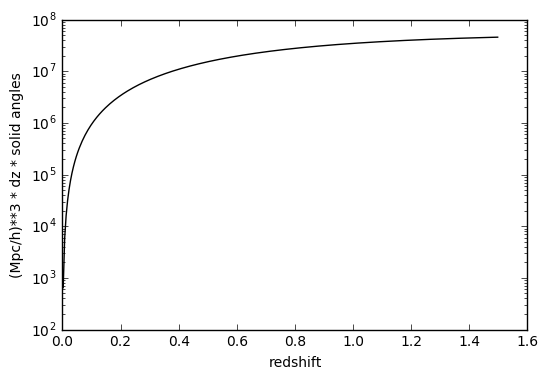

In [3]:
# ---
# Plot the comoving volume as function of redshift over the survey area - seems normal
# ---
pyplt.plot(REDSHIFT_BINS, COMOVING_VOLUMES, "k-")
pyplt.yscale("log")
pyplt.ylabel("(Mpc/h)**3 * dz * solid angles")
pyplt.xlabel("redshift")

In [4]:
# ---
# Load the 'pre-calculated' tinker mass function (number of clusters as a function of M500 and redshift)
# ---
# reading MF
PATH2MF         =       "../MFGENERATOR/MFLIB_MOCKS/mf_tinker_500.0_crit.pickle"
FF      =   open(PATH2MF, "rb")
HMFDICT =       pickle.load(FF)
FF.close()
# assign mass binning
mf_mass_bins         =   np.copy(HMFDICT["MASS_BINS" ])    # in unit of log10( Msun/h )
mf_mass_edges        =   np.copy(HMFDICT["MASS_EDGES"])    # in unit of log10( Msun/h )
mf_mass_step         =   np.copy(HMFDICT["MASS_STEP" ])    # in unit of log10( Msun/h )
# assign redshift binning
mf_redshift_bins     =   np.copy(HMFDICT["REDSHIFTS" ])
mf_redshift_step     =   np.copy(HMFDICT["REDSHIFTS_STEP"])
# extracting mass functions
mf_map_dndlog10m     =   np.copy(HMFDICT["dndlog10m" ])    # number density per unit of ( Mpc/h )^-3 per mass bin
                                                           # in the shape of (len(redshift_bins), len(mass_bins))
# interpolation of mass function
mf_dndlog10m_interpolate    =   interpolate.interp2d(
                                x=mf_mass_bins,
                                y=mf_redshift_bins,
                                z=mf_map_dndlog10m,
                                kind='linear')

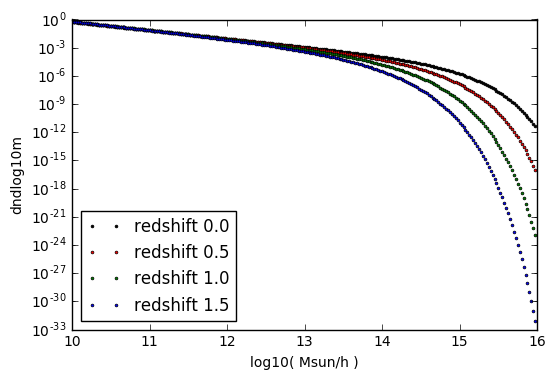

In [5]:
# ---
# Plot mass function - seems normal, high mass end is growing.
# ---
pyplt.figure("mass function")
pyplt.plot(mf_mass_bins, mf_dndlog10m_interpolate(mf_mass_bins, 0.0), "ko", label = "redshift 0.0", markersize = 2.0)
pyplt.plot(mf_mass_bins, mf_dndlog10m_interpolate(mf_mass_bins, 0.5), "ro", label = "redshift 0.5", markersize = 2.0)
pyplt.plot(mf_mass_bins, mf_dndlog10m_interpolate(mf_mass_bins, 1.0), "go", label = "redshift 1.0", markersize = 2.0)
pyplt.plot(mf_mass_bins, mf_dndlog10m_interpolate(mf_mass_bins, 1.5), "bo", label = "redshift 1.5", markersize = 2.0)
pyplt.xlabel("log10( Msun/h )")
pyplt.ylabel("dndlog10m")
pyplt.yscale("log")
pyplt.legend(loc=3)

In [6]:
# ---
# Calculate the numbers of clusters expected to see
# ---
# Extract the MF
# First get the mass function maps (mf_dndlog10m_interpolate(LOG10MASS_BINS, REDSHIFT_BINS)) [N/Volume/mass_step]
# second, we multiply it by volume as function of redshift [N/mass_step]
# third, we multipl the mass step
CLUSTERS_LIBRARY    =   np.array([
                            mf_dndlog10m_interpolate(LOG10MASS_BINS, REDSHIFT_BINS)[nz] * \
                            COMOVING_VOLUMES[nz] * \
                            LOG10MASS_STEPS
                            for nz in range(0,len(REDSHIFT_BINS)) ])

# Random sample
# CLUSTER_SAMPLE - using poisson distribution
CLUSTERS_COUNTS     =   np.random.poisson(lam=CLUSTERS_LIBRARY)

# Assign cluster mass and redshift
CLUSTER_LOG10MASSES =   np.array([])
CLUSTER_REDSHIFTS   =   np.array([])
# loop redshifts
for nz in range(0,len(REDSHIFT_BINS)):
    # loop masses
    for nm in range(0,len(LOG10MASS_BINS)):
        # if we have expected cluster number counts in this bin
        if    CLUSTERS_COUNTS[nz][nm] > 0:
            # we uniformly sample cluster mass between the mass bins
            CLUSTER_LOG10MASSES=   np.append(CLUSTER_LOG10MASSES,
                                   np.random.uniform(low=LOG10MASS_EDGES[:-1][nm], high=LOG10MASS_EDGES[1:][nm], size=CLUSTERS_COUNTS[nz][nm]) )
            # we uniformly sample cluster redshift between the redshift bins
            CLUSTER_REDSHIFTS  =   np.append(CLUSTER_REDSHIFTS,
                                   np.random.uniform(low=REDSHIFT_EDGES[ :-1][nz], high=REDSHIFT_EDGES[ 1:][nz], size=CLUSTERS_COUNTS[nz][nm]) )

# define NCLUSTERS
NCLUSTERS   =   len(CLUSTER_LOG10MASSES)

-83.2714748349
499


[14, 15, 0.1, 100]

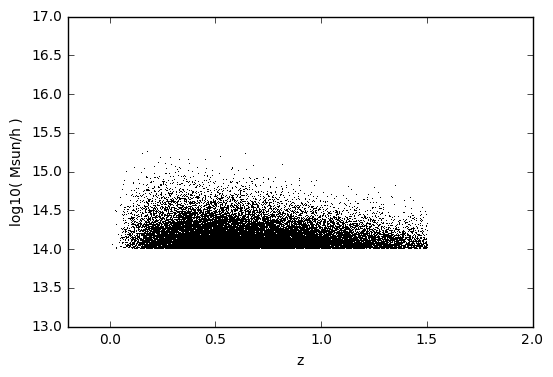

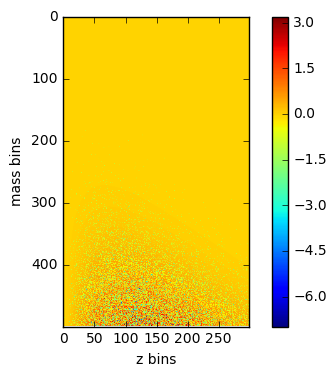

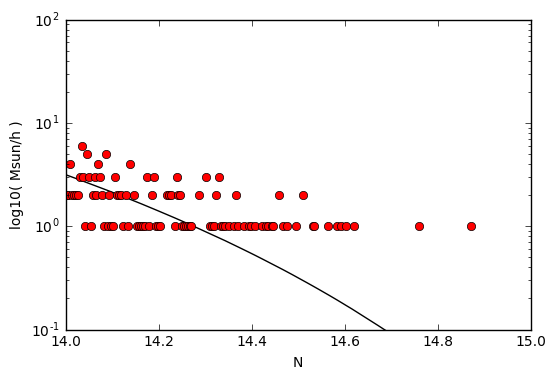

In [7]:
# ---
# Plot
# ---

# Now we have `true` mass and redshift of the clusters we sampled. Plot to check - seems normal
pyplt.figure("mz")
pyplt.plot(CLUSTER_REDSHIFTS, CLUSTER_LOG10MASSES, "k,")
pyplt.ylabel("log10( Msun/h )")
pyplt.xlabel("z")
pyplt.axis([-0.2,2.0,13.,17.0])

# plot the mass function map - seem consistent with zero, meaning the sample is correct.
pyplt.figure("mass function map")
mass_function_map = np.histogram2d(x = CLUSTER_LOG10MASSES, y = CLUSTER_REDSHIFTS, bins = [LOG10MASS_EDGES, REDSHIFT_EDGES])[0].T
pyplt.imshow(CLUSTERS_LIBRARY.T[::-1] - mass_function_map.T[::-1])
pyplt.colorbar()
pyplt.ylabel("mass bins")
pyplt.xlabel("z bins")
print np.sum(CLUSTERS_LIBRARY.T[::-1] - mass_function_map.T[::-1])


# plot mass function at redshift of 0.5 - mass function at z = 0.5 check, seems normal
pyplt.figure("mass function profile at z = 0.5")
redshift_index_use_me = np.argmin(np.abs(REDSHIFT_BINS - 0.5))
print len(mass_function_map[redshift_index_use_me])
pyplt.plot(LOG10MASS_BINS, CLUSTERS_LIBRARY[redshift_index_use_me], "k-" )
pyplt.plot(LOG10MASS_BINS, mass_function_map[redshift_index_use_me], "ro")
pyplt.yscale("log")
pyplt.xscale("linear")
pyplt.ylabel("log10( Msun/h )")
pyplt.xlabel("N")
pyplt.axis([14,15,0.1,100])


In [8]:
# ---
# define the input sr relation
# ---
def scaling_relation(mass, redshift, sr_params, calcinspaceof="log10", useez = False):
    """
    Scaling relation at the cluster redshift.
    
    Obs = A * (mass/Mpiv)**B * (E(cluster_redshift)/E(zpiv))**C
    
    Parameters:
        -`mass`     : float or 1d array. The mass in the unit of log10( Msun/h ).
        -`sr_params`: dictionary of scaling relation.
                It is in the following form.
                sr_params  =   {
                "A"      :   1.38E44,
                "Aerr"   :   0.12E44,
                "B"      :   2.08,
                "Berr"   :   0.13,
                "C"      :   7.0/3.0,
                "Cerr"   :   0.0,
                "D"      :   0.383,
                "Derr"   :   0.061,
                "Mpiv"   :   2E+14,
                "zpiv"   :   0.0,
                }
        -`calcinspaceof`: String. None in original value (linear scale).
                          "log10" in log10(value).
                          "ln"    in ln(value).
                          Default is in log10 because scaling relation 
                          typically is characterized in log10 space.
            
    Returns:
        -`sr`: the derived observable corresponding to
               cluster mass, redshift and scaling relation.
               The value is corresponding to calcinspaceof.
    """
    # calc the Ez
    Ez     = cosdist.e_z(redshift             ,**cosmo)
    Ezpiv  = cosdist.e_z(sr_params["zpiv"]    ,**cosmo)
    if   useez:
        # calc in log10 space
        log10sr   =   np.log10(sr_params["A"]) + \
                      sr_params["B"] * ( mass - np.log10(sr_params["Mpiv"]) ) + \
                      sr_params["C"] * ( np.log10(Ez/Ezpiv) )
    else:
        # calc in log10 space
        log10sr   =   np.log10(sr_params["A"]) + \
                      sr_params["B"] * ( mass - np.log10(sr_params["Mpiv"]) ) + \
                      sr_params["C"] * ( np.log10(1.0 + redshift) - np.log10(1.0 + sr_params["zpiv"]) )
    
    # return
    if   calcinspaceof   ==   "log10":
        return log10sr
    else:
        raise ValueError("calcinspaceof: " + calcinspaceof + " must be log10 for scaling relation." )
        
        



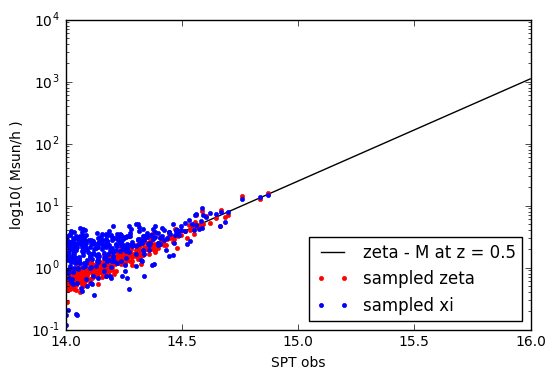

In [9]:
# ---
# Assigning observable xi for each cluster based on the `true` mass and redshift
# ---
# ZETA
# Assign value including the intrinsic scatter
# This is sampled in the log space, normal distribution with mean of 
# scaling_relation(CLUSTER_LOG10MASSES, CLUSTER_REDSHIFTS, sr_params = sr_xi_m, calcinspaceof="log10", useez = True)
# and scatter of lnD * log10(e) = log10D
CLUSTER_ZETA          =   10.0**np.random.normal(
                          loc    = scaling_relation(CLUSTER_LOG10MASSES, CLUSTER_REDSHIFTS, sr_params = sr_xi_m, calcinspaceof="log10", useez = True),
                          scale  = sr_xi_m["D"] * log10(e),
                          size   = NCLUSTERS)
# For each zeta, we sample based on normal distribution
# <xi>**2 = ZETA**2 + 3
CLUSTER_XI            =   np.random.normal(
                          loc    = np.sqrt( CLUSTER_ZETA**2 + 3.0 ),
                          scale  = 1.0 )
# Assign the measurement uncertainty - just one
CLUSTER_XIERR         =   np.ones( len(CLUSTER_XI) )


# plot to check - nothing wield
pyplt.plot(LOG10MASS_BINS, 
           10.0**scaling_relation(LOG10MASS_BINS, 0.5, sr_params = sr_xi_m, calcinspaceof="log10", useez = True), 
           "k-", label = "zeta - M at z = 0.5")
pyplt.plot(CLUSTER_LOG10MASSES[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           CLUSTER_ZETA[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           "r.", label = "sampled zeta"
          )
pyplt.plot(CLUSTER_LOG10MASSES[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           CLUSTER_XI[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           "b.", label = "sampled xi"
          )
pyplt.ylabel("log10( Msun/h )")
pyplt.xlabel("SPT obs")
pyplt.yscale("log")
pyplt.legend(loc = 4)

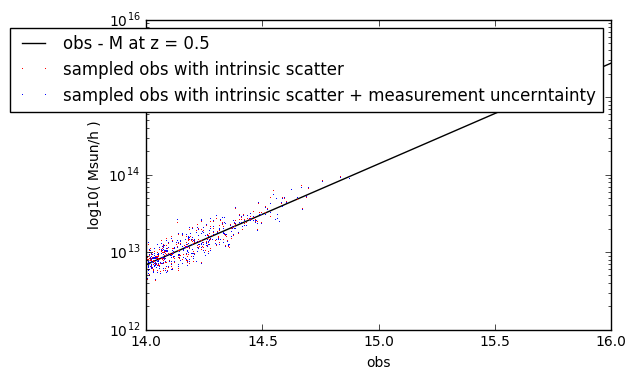

In [10]:
# ---
# Assign Obs (e.g. Mgas or Lx)
# ---
# Assign value including the intrinsic scatter
CLUSTER_LOBS_TRUE         =   10.0**np.random.normal(
                          loc    = scaling_relation(CLUSTER_LOG10MASSES, CLUSTER_REDSHIFTS, sr_params = sr_obs_m, calcinspaceof="log10", useez = True),
                          scale  = sr_obs_m["D"] * log10(e),
                          size   = NCLUSTERS )

# Assign the measurement uncertainty
# This is tricky here, we assume the measurement uncertainties to have fractional error to be 5% 0 7% according to each mass proxy (LOBS here).
# This is NOT convolving with measurement uncertainties YET.
CLUSTER_LOBSERR       =   CLUSTER_LOBS_TRUE * np.random.uniform(low=0.05, high=0.07, size=NCLUSTERS)

# Apply the measurement uncertainty
# This is to perturb the cluster LOBS given the fractional error and replace it back to CLUSTER_LOBS.
# After this step, the CLUSTER LOBS has intrinsic scatter and measurement unvertainties
CLUSTER_LOBS          =   np.random.normal(loc=CLUSTER_LOBS_TRUE, scale=CLUSTER_LOBSERR, size=None)

# plot
# plot to check - nothing wield
pyplt.plot(LOG10MASS_BINS, 
           10.0**scaling_relation(LOG10MASS_BINS, 0.5, sr_params = sr_obs_m, calcinspaceof="log10", useez = True), 
           "k-", label = "obs - M at z = 0.5")
pyplt.plot(CLUSTER_LOG10MASSES[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           CLUSTER_LOBS_TRUE[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           "r,", label = "sampled obs with intrinsic scatter"
          )
pyplt.plot(CLUSTER_LOG10MASSES[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           CLUSTER_LOBS[ np.abs(CLUSTER_REDSHIFTS - 0.5) < REDSHIFT_STEPS[0] ],
           "b,", label = "sampled obs with intrinsic scatter + measurement uncerntainty"
          )
pyplt.ylabel("log10( Msun/h )")
pyplt.xlabel("obs")
pyplt.yscale("log")
pyplt.legend(loc = 1)

In [11]:
# Selection
I_AM_IN_SURVEY        =   ( CLUSTER_XI >= 5.0 )

############################################
#
# Output
#
#############################################


FF      =       open(PATH2OUTCAT, "w")
header_fformat      =       "#     clusterid    redshift    m500[log10(M/(Msun~h^-1))]    xi    xierr    selected    obs[10^13Msun]    obserr[10^13Msun]    zeta    "
FF.write(header_fformat+"    \n")

for i in np.array(xrange(0, NCLUSTERS)):
    fformat = "     " + str(i) + \
              "     " + "%.3f" %  CLUSTER_REDSHIFTS[i] + \
              "     " + "%.5f" %  CLUSTER_LOG10MASSES[i] + \
              "     " + "%.4f" % (CLUSTER_XI[i]) + \
              "     " + "%.4f" % (CLUSTER_XIERR[i]) + \
              "     " + "%i"   % (I_AM_IN_SURVEY[i]) + \
              "     " + "%.4f" % (CLUSTER_LOBS[i]/1E13) + \
              "     " + "%.4f" % (CLUSTER_LOBSERR[i]/1E13) + \
              "     " + "%.4f" % (CLUSTER_ZETA[i])
    FF.write(fformat+"    " + "\n")
FF.close()

FF      =       open(PATH2OUTCAT+".in_survey", "w")
header_fformat      =       "#     clusterid    redshift    m500[log10(M/(Msun~h^-1))]    xi    xierr    selected    obs[10^13Msun]    obserr[10^13Msun]    zeta    "
FF.write(header_fformat+"    \n")

for i in np.array(xrange(0, NCLUSTERS))[ I_AM_IN_SURVEY ]:
    fformat = "     " + str(i) + \
              "     " + "%.3f" % CLUSTER_REDSHIFTS[i] + \
              "     " + "%.5f" % CLUSTER_LOG10MASSES[i] + \
              "     " + "%.4f" % (CLUSTER_XI[i]) + \
              "     " + "%.4f" % (CLUSTER_XIERR[i]) + \
              "     " + "%i"   % (I_AM_IN_SURVEY[i]) + \
              "     " + "%.4f" % (CLUSTER_LOBS[i]/1E13) + \
              "     " + "%.4f" % (CLUSTER_LOBSERR[i]/1E13) + \
              "     " + "%.4f" % (CLUSTER_ZETA[i])
    FF.write(fformat+"    " + "\n")
FF.close()

